# Homework 1. Formalization of ML task

## Homework description

Theory (5 points):
- Read `Explore` comments. Follow links
- Answer theory questions in Google From 

Practice (10 points):
- Apply [From business task to formalized ML task](#From_business_task_to_formalized_ML_task) pipeline on [CommonLit - Evaluate Student Summaries
](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries)
    - We encorouge you to explore [existing EDA](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/code). Unite information from lecture and existing EDA and make your own best EDA
    - Take into account all `TODOs` left by us in code. They might give you good insights
- Advanced: Take a look at `TODOs` one more time. Maybe you can improve our notebook 

## Setup

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import gensim
import nltk
import spacy
import re
import spacy
import matplotlib.pyplot as plt

/home/evgeniy/.local/bin/miniconda3/envs/iasa_nlp_env/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/evgeniy/.local/bin/miniconda3/envs/iasa_nlp_env/lib/python3.9/site-packages/torch/cuda/__init__.py:529: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


### Download data

In [ ]:
!mkdir ../data
!cd ../data/
!kaggle competitions download -c commonlit-evaluate-student-summaries
!unzip commonlit-evaluate-student-summaries.zip
!rm commonlit-evaluate-student-summaries.zip 
!mkdir commonlit-evaluate-student-summaries
!mv *.csv commonlit-evaluate-student-summaries/

## 1. Business Understanding

The project aims to develop a model for evaluating the quality of summaries written by students in grades 3-12. Summary writing is a crucial skill that enhances reading comprehension, especially for second language learners and students with learning disabilities. It promotes critical thinking and serves as an effective means to improve writing abilities. The main focus of the project is on assessing how well a student represents the main idea and details of a given source text, alongside evaluating the clarity, precision, and fluency of the language used in the summary. 

The primary beneficiaries of the project are teachers and students. Teachers will benefit from a time-efficient tool that facilitates quick and effective evaluation of student summaries. Students can use this tool to receive immediate feedback on their work, thus producing more dynamic learning process. 

## 2. Data Understanding

### Dataset structure

The provided dataset consists of two parts: prompts, i.e. summarization tasks, given to students, and actual students summaries. Train part of those summaries also contains the assigned score. Thus the task falls into the category of **supervised learning**. There is no missing values in dataset.

In [2]:
os.listdir("../data/commonlit-evaluate-student-summaries/")

['summaries_train.csv',
 'sample_submission.csv',
 'prompts_test.csv',
 'prompts_train.csv',
 'summaries_test.csv']

In [3]:
prompts_train = pd.read_csv("../data/commonlit-evaluate-student-summaries/prompts_train.csv")
summaries_train = pd.read_csv("../data/commonlit-evaluate-student-summaries/summaries_train.csv")

prompts_test = pd.read_csv("../data/commonlit-evaluate-student-summaries/prompts_test.csv")
summaries_test = pd.read_csv("../data/commonlit-evaluate-student-summaries/summaries_test.csv")

sample_submission = pd.read_csv("../data/commonlit-evaluate-student-summaries/sample_submission.csv")

In [4]:
prompts_train.shape, summaries_train.shape

((4, 4), (7165, 5))

In [5]:
prompts_test.shape, summaries_test.shape

((2, 4), (4, 3))

In [6]:
prompts_train

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [7]:
print(prompts_train.loc[0, 'prompt_title'])
print(prompts_train.loc[0, 'prompt_question'])
print(prompts_train.loc[0, 'prompt_text'])

On Tragedy
Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.
Chapter 13 
As the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. 
A perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity or fear. Nor, again, 

In [8]:
summaries_train.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [9]:
summaries_train.isna().any()

student_id    False
prompt_id     False
text          False
content       False
wording       False
dtype: bool

### Target values

The target, i.e. the score of the student's summary, consists of two parts: *wording score* an *content score*. Those scores are provided for the train part, yet there is no explicit description what criteries were used for those scores during the evaluation.

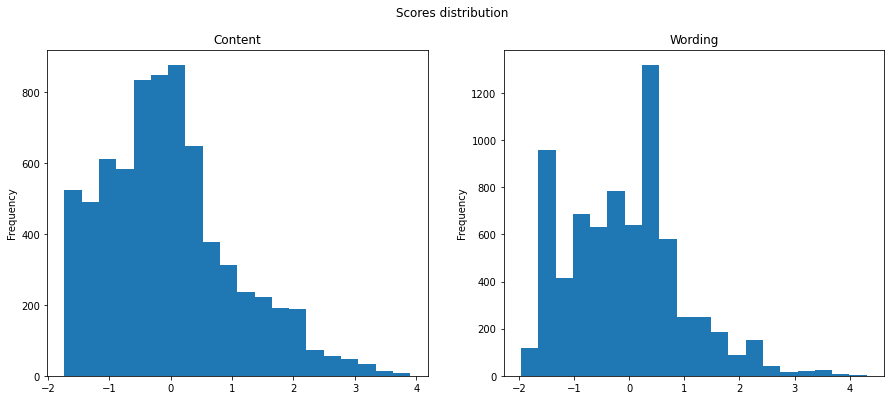

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axs[0].set_title("Content")
axs[1].set_title("Wording")
summaries_train['content'].plot(kind='hist', bins=20, ax=axs[0])
summaries_train['wording'].plot(kind='hist', bins=20, ax=axs[1])
plt.suptitle("Scores distribution")
plt.show()

From the hist plots we can assume that possible range for both scores is (-2, 5)

### Evaluation Metric

The performance of the model will be estimated based on the mean columnwise RMSE:

$$MCRMSE = \frac{1}{N_t} \sum\limits_{j=1}^{N_t} \left(\frac1n \sum\limits_{i=1}^n (y_{ij} - \hat{y}_ij)\right)^2$$

In our case there are two target values, i.e. $N_t = 2$. Since the number of independent RMSEs is fixed, minimization of the MCRMSE is equivalent to the separate minimization of RMSE for each target value.

## 3. Data Preparation

### 3.1. EDA

### 3.2. Data preprocessing

## 4. Modeling 

## 5. Evaluation